# Reliability & Uncertainty Analysis of LLM Reasoning

This notebook computes all research metrics and generates visualizations
from the scored experiment data.

**Metrics computed:**
1. Accuracy (per prompt, temperature, category, difficulty)
2. Variance / instability (disagreement rate, flip rate)
3. Calibration / overconfidence (confidence vs correctness, ECE)
4. Parse failure rates
5. Failure mode summary (from manual labels)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)

# Paths
ROOT = Path('..').resolve()
SCORES_PATH = ROOT / 'results' / 'scores.csv'
GENERATIONS_PATH = ROOT / 'results' / 'generations.jsonl'
FIGURES_DIR = ROOT / 'results' / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f'Project root: {ROOT}')
print(f'Scores file exists: {SCORES_PATH.exists()}')

Project root: /Users/amuujin/Desktop/Reliability & Uncertainty Analysis of LLM Reasoning/Reliability-Uncertainty-Analysis-of-LLM-Reasoning
Scores file exists: True


## 1. Load Data

In [2]:
df = pd.read_csv(SCORES_PATH)

# Basic info
print(f'Total scored records: {len(df)}')
print(f'Unique questions:     {df.question_id.nunique()}')
print(f'Prompts:              {df.prompt_name.unique().tolist()}')
print(f'Temperatures:         {sorted(df.temperature.unique())}')
print(f'Runs per condition:   {df.run_index.nunique()}')
print()
df.head()

Total scored records: 1810
Unique questions:     100
Prompts:              ['direct', 'step_by_step', 'uncertainty_aware']
Temperatures:         [0.0, 0.7]
Runs per condition:   5



,question_id,category,difficulty,prompt_name,temperature,run_index,parsed_answer,ground_truth,is_correct,is_unknown,confidence,parse_success,match_type
0,Q001,arithmetic,easy,direct,0.0,1,10,10,True,False,100.0,True,numeric
1,Q001,arithmetic,easy,direct,0.0,2,10,10,True,False,100.0,True,numeric
2,Q001,arithmetic,easy,direct,0.0,3,10,10,True,False,100.0,True,numeric
3,Q001,arithmetic,easy,direct,0.0,4,10,10,True,False,100.0,True,numeric
4,Q001,arithmetic,easy,direct,0.0,5,10,10,True,False,100.0,True,numeric


## 2. Metric A — Accuracy

In [3]:
# Overall accuracy by prompt × temperature
acc = df.groupby(['prompt_name', 'temperature'])['is_correct'].agg(['mean', 'count', 'sum'])
acc.columns = ['accuracy', 'n', 'n_correct']
acc['accuracy_pct'] = (acc['accuracy'] * 100).round(2)

# 95% CI (Wilson score interval approximation)
z = 1.96
p = acc['accuracy']
n = acc['n']
acc['ci_low'] = ((p + z**2/(2*n) - z * np.sqrt((p*(1-p) + z**2/(4*n))/n)) / (1 + z**2/n) * 100).round(2)
acc['ci_high'] = ((p + z**2/(2*n) + z * np.sqrt((p*(1-p) + z**2/(4*n))/n)) / (1 + z**2/n) * 100).round(2)

print('=== Accuracy by Prompt × Temperature ===')
print(acc[['accuracy_pct', 'ci_low', 'ci_high', 'n']].to_string())

=== Accuracy by Prompt × Temperature ===
                               accuracy_pct  ci_low  ci_high    n
prompt_name       temperature                                    
direct            0.0                 85.43   81.01    88.96  302
                  0.7                 85.43   81.01    88.96  302
step_by_step      0.0                 91.06   87.30    93.78  302
                  0.7                 91.72   88.07    94.33  302
uncertainty_aware 0.0                 87.42   83.20    90.69  302
                  0.7                 88.67   84.58    91.78  300


In [4]:
# Accuracy by category
cat_acc = df.groupby(['category', 'prompt_name', 'temperature'])['is_correct'].mean().unstack(['prompt_name', 'temperature'])
print('\n=== Accuracy by Category ===')
print((cat_acc * 100).round(1).to_string())


=== Accuracy by Category ===
prompt_name direct       step_by_step       uncertainty_aware      
temperature    0.0   0.7          0.0   0.7               0.0   0.7
category                                                           
arithmetic    93.4  95.1         97.5  97.5              97.5  95.8
logic         83.3  82.2         86.7  88.9              81.1  86.7
multi_step    76.7  75.6         86.7  86.7              80.0  81.1


In [5]:
# Accuracy by difficulty
diff_acc = df.groupby(['difficulty', 'prompt_name', 'temperature'])['is_correct'].mean().unstack(['prompt_name', 'temperature'])
print('\n=== Accuracy by Difficulty ===')
print((diff_acc * 100).round(1).to_string())


=== Accuracy by Difficulty ===
prompt_name direct        step_by_step        uncertainty_aware       
temperature    0.0    0.7          0.0    0.7               0.0    0.7
difficulty                                                            
easy         100.0  100.0        100.0  100.0             100.0  100.0
hard          65.7   65.7         76.5   79.4              72.5   75.5
medium        90.9   90.9         97.0   96.0              89.9   90.9


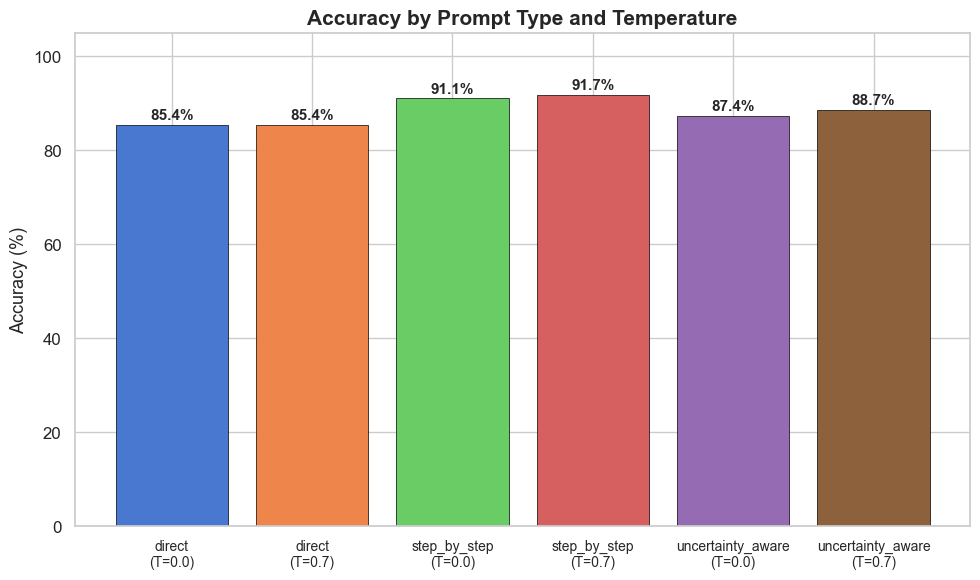

In [6]:
# Plot 1: Accuracy bar chart
fig, ax = plt.subplots(figsize=(10, 6))

plot_data = df.groupby(['prompt_name', 'temperature'])['is_correct'].mean().reset_index()
plot_data['label'] = plot_data['prompt_name'] + '\n(T=' + plot_data['temperature'].astype(str) + ')'
plot_data['accuracy'] = plot_data['is_correct'] * 100

colors = sns.color_palette('muted', n_colors=len(plot_data))
bars = ax.bar(plot_data['label'], plot_data['accuracy'], color=colors, edgecolor='black', linewidth=0.5)

# Add value labels
for bar, val in zip(bars, plot_data['accuracy']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontsize=13)
ax.set_title('Accuracy by Prompt Type and Temperature', fontsize=15, fontweight='bold')
ax.set_ylim(0, 105)
ax.tick_params(axis='x', labelsize=10)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'accuracy_by_prompt_temp.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Metric B — Variance / Instability

In [7]:
# For each (question, prompt, temp) group: count unique answers across runs
variance = df.groupby(['question_id', 'prompt_name', 'temperature']).agg(
    n_unique_answers=('parsed_answer', 'nunique'),
    n_runs=('run_index', 'count'),
    n_correct=('is_correct', 'sum'),
).reset_index()

variance['has_disagreement'] = (variance['n_unique_answers'] > 1).astype(int)
variance['is_flip'] = ((variance['n_correct'] > 0) & (variance['n_correct'] < variance['n_runs'])).astype(int)

# Aggregate
var_summary = variance.groupby(['prompt_name', 'temperature']).agg(
    disagreement_rate=('has_disagreement', 'mean'),
    flip_rate=('is_flip', 'mean'),
    avg_unique_answers=('n_unique_answers', 'mean'),
).reset_index()

var_summary['disagreement_pct'] = (var_summary['disagreement_rate'] * 100).round(1)
var_summary['flip_pct'] = (var_summary['flip_rate'] * 100).round(1)

print('=== Variance / Instability ===')
print(var_summary.to_string(index=False))

=== Variance / Instability ===
      prompt_name  temperature  disagreement_rate  flip_rate  avg_unique_answers  disagreement_pct  flip_pct
           direct          0.0               0.01       0.01                1.01               1.0       1.0
           direct          0.7               0.03       0.03                1.04               3.0       3.0
     step_by_step          0.0               0.00       0.00                0.98               0.0       0.0
     step_by_step          0.7               0.05       0.04                1.05               5.0       4.0
uncertainty_aware          0.0               0.03       0.04                1.03               3.0       4.0
uncertainty_aware          0.7               0.07       0.07                1.09               7.0       7.0


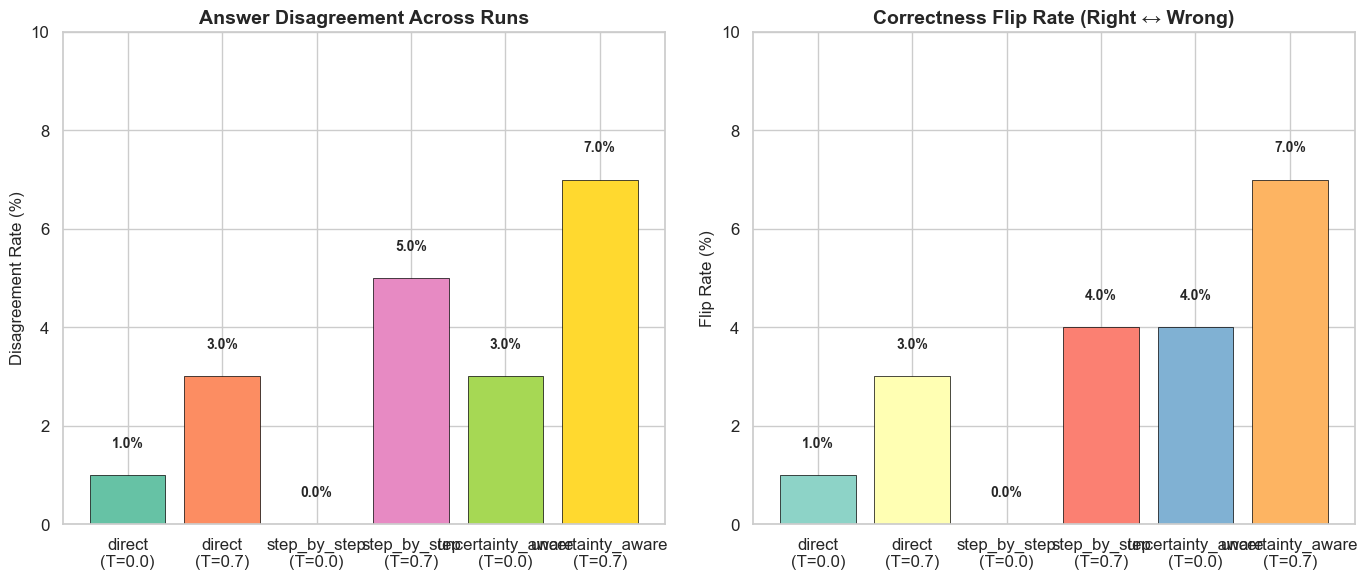

In [8]:
# Plot 2: Disagreement rate bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

var_summary['label'] = var_summary['prompt_name'] + '\n(T=' + var_summary['temperature'].astype(str) + ')'

# Disagreement rate
ax = axes[0]
bars = ax.bar(var_summary['label'], var_summary['disagreement_pct'],
              color=sns.color_palette('Set2', len(var_summary)), edgecolor='black', linewidth=0.5)
for bar, val in zip(bars, var_summary['disagreement_pct']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.set_ylabel('Disagreement Rate (%)', fontsize=12)
ax.set_title('Answer Disagreement Across Runs', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(var_summary['disagreement_pct'].max() * 1.3, 10))

# Flip rate
ax = axes[1]
bars = ax.bar(var_summary['label'], var_summary['flip_pct'],
              color=sns.color_palette('Set3', len(var_summary)), edgecolor='black', linewidth=0.5)
for bar, val in zip(bars, var_summary['flip_pct']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.set_ylabel('Flip Rate (%)', fontsize=12)
ax.set_title('Correctness Flip Rate (Right ↔ Wrong)', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(var_summary['flip_pct'].max() * 1.3, 10))

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'variance_instability.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Metric C — Calibration & Overconfidence

In [9]:
# Filter to rows with valid confidence
df_conf = df[df['confidence'].notna() & (df['confidence'] != '')].copy()
df_conf['confidence'] = df_conf['confidence'].astype(float)

print(f'Records with confidence scores: {len(df_conf)} / {len(df)}')

# Mean confidence correct vs wrong
conf_by_correct = df_conf.groupby(['prompt_name', 'temperature', 'is_correct'])['confidence'].mean().unstack('is_correct')
conf_by_correct.columns = ['Wrong', 'Correct']
print('\n=== Mean Confidence by Correctness ===')
print(conf_by_correct.round(1).to_string())

# High-confidence wrong rate
hc_wrong = df_conf[(df_conf['confidence'] >= 80) & (~df_conf['is_correct'])]
hc_wrong_rate = len(hc_wrong) / len(df_conf) * 100
print(f'\nHigh-confidence wrong rate (conf>=80 & wrong): {hc_wrong_rate:.1f}%')

# Low-confidence right rate
lc_right = df_conf[(df_conf['confidence'] < 50) & (df_conf['is_correct'])]
lc_right_rate = len(lc_right) / len(df_conf) * 100
print(f'Low-confidence right rate (conf<50 & correct): {lc_right_rate:.1f}%')

Records with confidence scores: 1795 / 1810

=== Mean Confidence by Correctness ===
                               Wrong  Correct
prompt_name       temperature                
direct            0.0          100.0    100.0
                  0.7          100.0    100.0
step_by_step      0.0          100.0    100.0
                  0.7          100.0    100.0
uncertainty_aware 0.0          100.0    100.0
                  0.7          100.0    100.0

High-confidence wrong rate (conf>=80 & wrong): 11.0%
Low-confidence right rate (conf<50 & correct): 0.0%


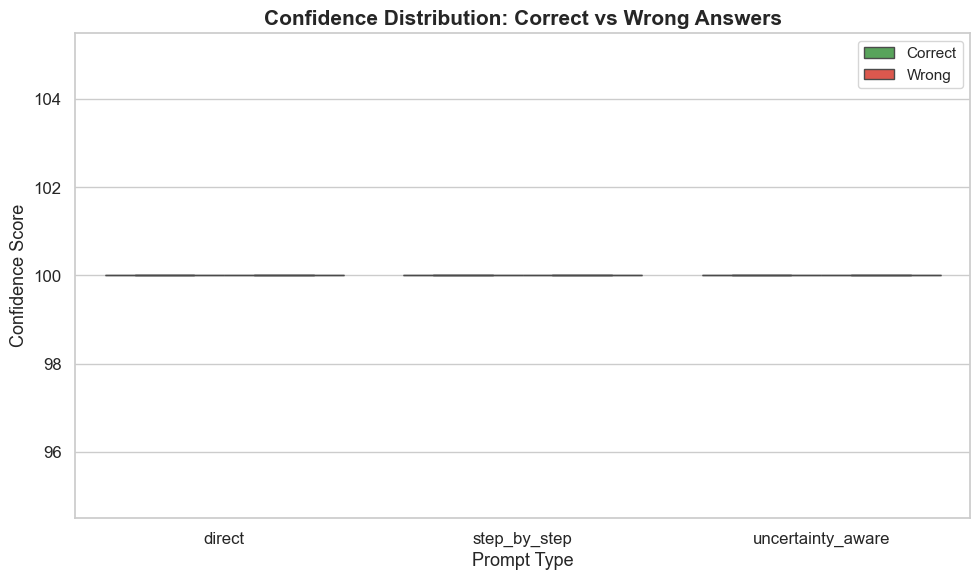

In [10]:
# Plot 3: Confidence vs Correctness box plot
fig, ax = plt.subplots(figsize=(10, 6))

df_conf['correctness'] = df_conf['is_correct'].map({True: 'Correct', False: 'Wrong'})
sns.boxplot(data=df_conf, x='prompt_name', y='confidence', hue='correctness',
            ax=ax, palette={'Correct': '#4CAF50', 'Wrong': '#F44336'})

ax.set_xlabel('Prompt Type', fontsize=13)
ax.set_ylabel('Confidence Score', fontsize=13)
ax.set_title('Confidence Distribution: Correct vs Wrong Answers', fontsize=15, fontweight='bold')
ax.legend(title='', fontsize=11)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'confidence_vs_correctness.png', dpi=300, bbox_inches='tight')
plt.show()

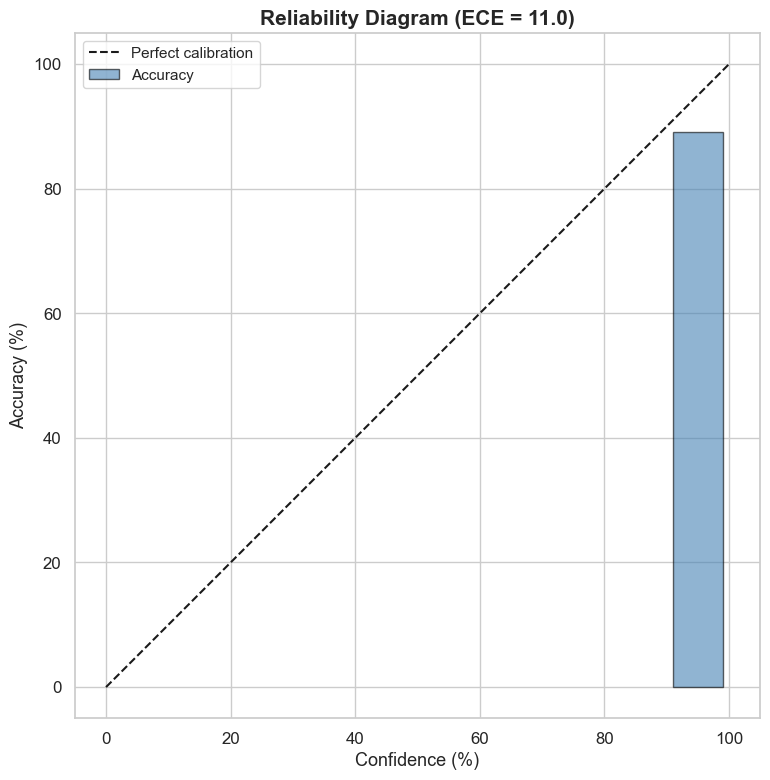


Expected Calibration Error (ECE): 10.97


In [11]:
# Plot 4: Reliability diagram (Expected Calibration Error)
def compute_ece(confidences, correctness, n_bins=10):
    """Compute Expected Calibration Error."""
    bin_boundaries = np.linspace(0, 100, n_bins + 1)
    bin_centers = []
    bin_accs = []
    bin_confs = []
    bin_counts = []

    for i in range(n_bins):
        lo, hi = bin_boundaries[i], bin_boundaries[i + 1]
        mask = (confidences >= lo) & (confidences < hi) if i < n_bins - 1 else (confidences >= lo) & (confidences <= hi)
        if mask.sum() == 0:
            continue
        bin_centers.append((lo + hi) / 2)
        bin_accs.append(correctness[mask].mean() * 100)
        bin_confs.append(confidences[mask].mean())
        bin_counts.append(mask.sum())

    bin_centers = np.array(bin_centers)
    bin_accs = np.array(bin_accs)
    bin_confs = np.array(bin_confs)
    bin_counts = np.array(bin_counts)

    ece = np.sum(bin_counts / bin_counts.sum() * np.abs(bin_accs - bin_confs))
    return ece, bin_centers, bin_accs, bin_confs, bin_counts


fig, ax = plt.subplots(figsize=(8, 8))

confidences = df_conf['confidence'].values
correctness = df_conf['is_correct'].values.astype(float)

ece, centers, accs, confs, counts = compute_ece(confidences, correctness)

ax.bar(centers, accs, width=8, alpha=0.6, color='steelblue', edgecolor='black', label='Accuracy')
ax.plot([0, 100], [0, 100], 'k--', linewidth=1.5, label='Perfect calibration')
ax.set_xlabel('Confidence (%)', fontsize=13)
ax.set_ylabel('Accuracy (%)', fontsize=13)
ax.set_title(f'Reliability Diagram (ECE = {ece:.1f})', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)
ax.set_aspect('equal')
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'reliability_diagram.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\nExpected Calibration Error (ECE): {ece:.2f}')

## 5. UNKNOWN Analysis (Uncertainty-Aware Prompt)

In [12]:
# UNKNOWN rate for uncertainty_aware prompt
ua = df[df['prompt_name'] == 'uncertainty_aware'].copy()

if len(ua) > 0:
    unknown_rate = ua['is_unknown'].mean() * 100
    error_rate = (~ua['is_correct'] & ~ua['is_unknown']).mean() * 100
    correct_rate = ua['is_correct'].mean() * 100

    print('=== Uncertainty-Aware Prompt Analysis ===')
    print(f'  Correct:     {correct_rate:.1f}%')
    print(f'  Wrong:       {error_rate:.1f}%')
    print(f'  UNKNOWN:     {unknown_rate:.1f}%')

    # Breakdown by temperature
    for t in sorted(ua['temperature'].unique()):
        sub = ua[ua['temperature'] == t]
        print(f'\n  Temperature = {t}:')
        print(f'    Correct:  {sub["is_correct"].mean()*100:.1f}%')
        print(f'    Wrong:    {(~sub["is_correct"] & ~sub["is_unknown"]).mean()*100:.1f}%')
        print(f'    UNKNOWN:  {sub["is_unknown"].mean()*100:.1f}%')
else:
    print('No uncertainty_aware data found.')

=== Uncertainty-Aware Prompt Analysis ===
  Correct:     88.0%
  Wrong:       11.6%
  UNKNOWN:     0.3%

  Temperature = 0.0:
    Correct:  87.4%
    Wrong:    12.3%
    UNKNOWN:  0.3%

  Temperature = 0.7:
    Correct:  88.7%
    Wrong:    11.0%
    UNKNOWN:  0.3%


## 6. Parse Failure Analysis

In [13]:
parse_fail = df.groupby(['prompt_name', 'temperature'])['parse_success'].agg(
    total='count',
    success='sum',
).reset_index()
parse_fail['fail_count'] = parse_fail['total'] - parse_fail['success']
parse_fail['fail_rate_pct'] = ((parse_fail['fail_count'] / parse_fail['total']) * 100).round(2)

print('=== Parse Failure Rates ===')
print(parse_fail.to_string(index=False))

=== Parse Failure Rates ===
      prompt_name  temperature  total  success  fail_count  fail_rate_pct
           direct          0.0    302      302           0           0.00
           direct          0.7    302      302           0           0.00
     step_by_step          0.0    302      296           6           1.99
     step_by_step          0.7    302      299           3           0.99
uncertainty_aware          0.0    302      298           4           1.32
uncertainty_aware          0.7    300      298           2           0.67


## 7. Heatmap: Category × Prompt Accuracy

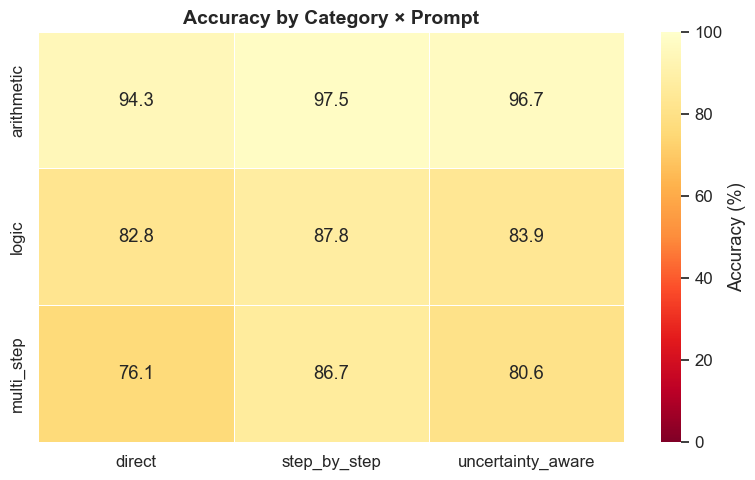

In [14]:
# Heatmap
heat_data = df.groupby(['category', 'prompt_name'])['is_correct'].mean().unstack('prompt_name') * 100

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(heat_data, annot=True, fmt='.1f', cmap='YlOrRd_r', cbar_kws={'label': 'Accuracy (%)'},
            linewidths=0.5, ax=ax, vmin=0, vmax=100)
ax.set_title('Accuracy by Category × Prompt', fontsize=14, fontweight='bold')
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'heatmap_category_prompt.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Failure Mode Analysis

Load manually-labeled failure modes (if available).

In [15]:
failure_modes_path = ROOT / 'results' / 'failure_modes.csv'

if failure_modes_path.exists():
    fm = pd.read_csv(failure_modes_path)
    print(f'Loaded {len(fm)} failure mode labels')

    # Distribution
    fm_counts = fm['failure_mode'].value_counts()
    print('\n=== Failure Mode Distribution ===')
    print(fm_counts.to_string())

    # Plot 5: Failure mode bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    fm_counts.plot.barh(ax=ax, color=sns.color_palette('coolwarm', len(fm_counts)),
                        edgecolor='black', linewidth=0.5)
    ax.set_xlabel('Count', fontsize=13)
    ax.set_title('Failure Mode Distribution', fontsize=15, fontweight='bold')
    ax.invert_yaxis()
    for i, (val, name) in enumerate(zip(fm_counts.values, fm_counts.index)):
        ax.text(val + 0.3, i, str(val), va='center', fontsize=11, fontweight='bold')
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / 'failure_modes.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print('No failure_modes.csv found. Skipping failure mode analysis.')
    print('To add: create results/failure_modes.csv with columns:')
    print('  question_id, prompt_name, temperature, run_index, failure_mode, notes, example_snippet')

No failure_modes.csv found. Skipping failure mode analysis.
To add: create results/failure_modes.csv with columns:
  question_id, prompt_name, temperature, run_index, failure_mode, notes, example_snippet


## 9. Summary Statistics

In [16]:
print('=' * 60)
print('EXPERIMENT SUMMARY')
print('=' * 60)
print(f'Model:               {df["model"].iloc[0] if "model" in df.columns else "N/A"}')
print(f'Total records:       {len(df)}')
print(f'Questions:           {df.question_id.nunique()}')
print(f'Prompts:             {df.prompt_name.unique().tolist()}')
print(f'Temperatures:        {sorted(df.temperature.unique())}')
print(f'Runs per condition:  {df.run_index.nunique()}')
print(f'Overall accuracy:    {df.is_correct.mean()*100:.1f}%')
print(f'Parse success rate:  {df.parse_success.mean()*100:.1f}%')
print(f'UNKNOWN rate:        {df.is_unknown.mean()*100:.1f}%')

if len(df_conf) > 0:
    print(f'Mean confidence:     {df_conf.confidence.mean():.1f}')
    print(f'ECE:                 {ece:.2f}')
    print(f'Overconfident wrong: {hc_wrong_rate:.1f}%')

print('\n=== Best/Worst Conditions ===')
best = df.groupby(['prompt_name', 'temperature'])['is_correct'].mean().idxmax()
worst = df.groupby(['prompt_name', 'temperature'])['is_correct'].mean().idxmin()
print(f'Best:  {best[0]} @ T={best[1]}  ({df.groupby(["prompt_name","temperature"])["is_correct"].mean().max()*100:.1f}%)')
print(f'Worst: {worst[0]} @ T={worst[1]} ({df.groupby(["prompt_name","temperature"])["is_correct"].mean().min()*100:.1f}%)')
print('=' * 60)

EXPERIMENT SUMMARY
Model:               N/A
Total records:       1810
Questions:           100
Prompts:             ['direct', 'step_by_step', 'uncertainty_aware']
Temperatures:        [0.0, 0.7]
Runs per condition:  5
Overall accuracy:    88.3%
Parse success rate:  99.2%
UNKNOWN rate:        0.1%
Mean confidence:     100.0
ECE:                 10.97
Overconfident wrong: 11.0%

=== Best/Worst Conditions ===
Best:  step_by_step @ T=0.7  (91.7%)
Worst: direct @ T=0.0 (85.4%)
